Dataset shape: (1338, 7)
   age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB
None

Missing values per column:
 age         0
sex         0
bmi      

C:\Users\IT SOLUTION\AppData\Roaming\Python\Python313\site-packages\statsmodels\genmod\families\links.py:13: FutureWarning: The log link alias is deprecated. Use Log instead. The log link alias will be removed after the 0.15.0 release.
  warnings.warn(



Gamma Regression Summary:
                 Generalized Linear Model Regression Results                  
Dep. Variable:                charges   No. Observations:                 1070
Model:                            GLM   Df Residuals:                     1043
Model Family:                   Gamma   Df Model:                           26
Link Function:                    log   Scale:                         0.45958
Method:                          IRLS   Log-Likelihood:                -10596.
Date:                Tue, 12 Aug 2025   Deviance:                       217.37
Time:                        01:43:55   Pearson chi2:                     479.
No. Iterations:                    15   Pseudo R-squ. (CS):             0.7095
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------

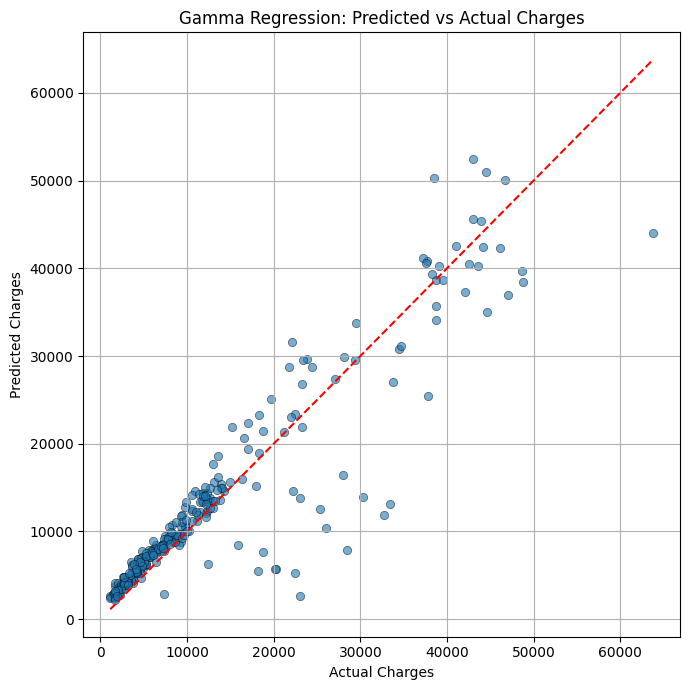

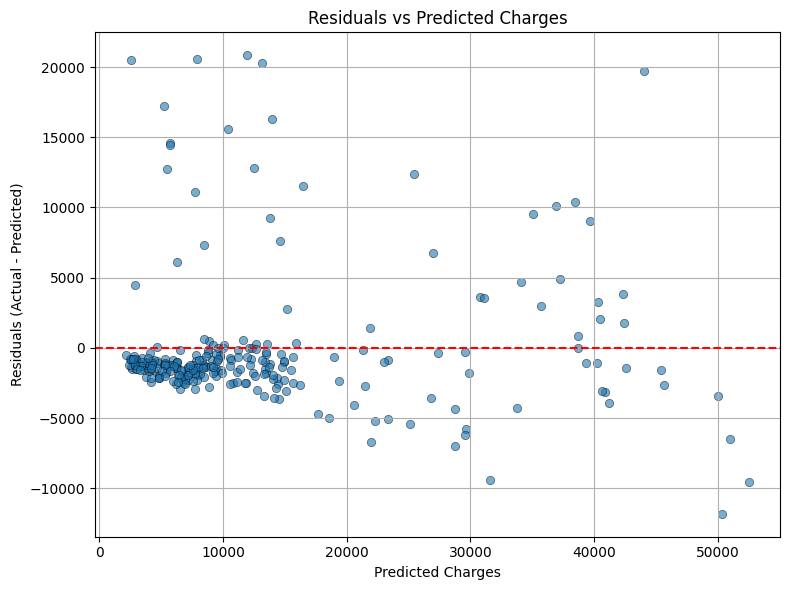

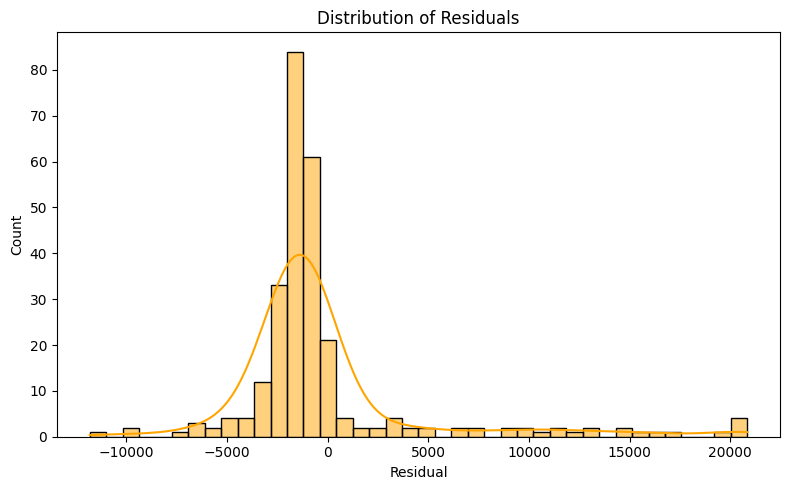

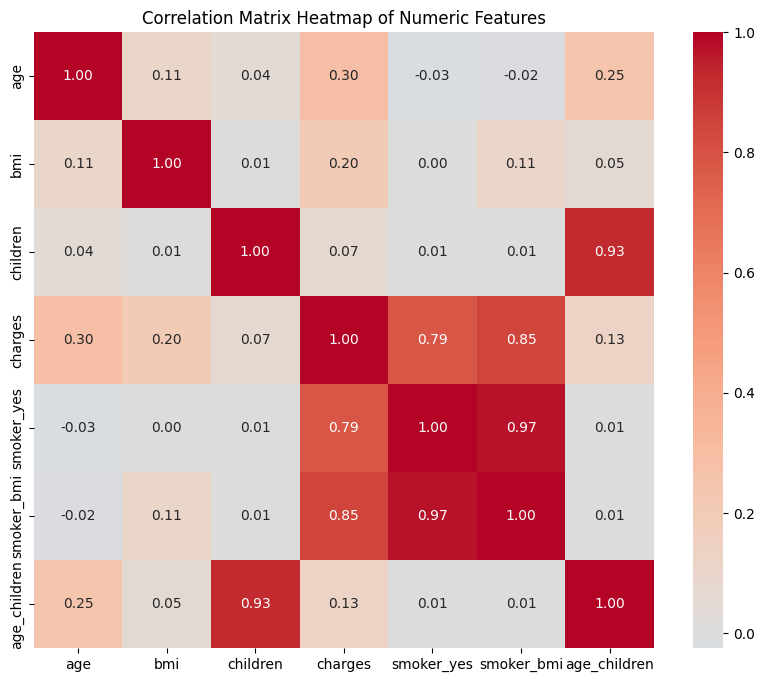

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# --- 1. Load dataset
df = pd.read_csv("insurance.csv")

# --- 2. Basic EDA & Cleaning
print("Dataset shape:", df.shape)
print(df.head())
print(df.info())
print("\nMissing values per column:\n", df.isnull().sum())

# --- 3. Domain-specific feature: BMI category
def bmi_category(bmi):
    if bmi < 18.5:
        return 'underweight'
    elif bmi < 25:
        return 'normal'
    elif bmi < 30:
        return 'overweight'
    else:
        return 'obese'

df['bmi_cat'] = df['bmi'].apply(bmi_category)

# --- 4. Interaction terms: smoker*bmi, age*children
df['smoker_yes'] = (df['smoker'] == 'yes').astype(int)
df['smoker_bmi'] = df['smoker_yes'] * df['bmi']
df['age_children'] = df['age'] * df['children']

# --- 5. Define features and target
target = 'charges'

features = ['age', 'bmi', 'children', 'sex', 'smoker', 'region', 'bmi_cat', 'smoker_bmi', 'age_children']

X = df[features]
y = df[target]

# --- 6. Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# --- 7. Separate numeric & categorical columns
numeric_features = ['age', 'bmi', 'children', 'smoker_bmi', 'age_children']
categorical_features = ['sex', 'smoker', 'region', 'bmi_cat']

# --- 8. Pipelines for preprocessing
numeric_transformer = Pipeline([
    ('poly', PolynomialFeatures(degree=2, include_bias=False)), 
    ('scaler', StandardScaler())
])

categorical_transformer = Pipeline([
    ('onehot', OneHotEncoder(drop='first', sparse_output=False))  
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, numeric_features),
    ('cat', categorical_transformer, categorical_features)
])

# --- 9. Preprocess train and test data
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

# --- 10. Get feature names after preprocessing
num_poly_features = preprocessor.named_transformers_['num']['poly'].get_feature_names_out(numeric_features)
cat_features = preprocessor.named_transformers_['cat']['onehot'].get_feature_names_out(categorical_features)
feature_names = np.concatenate([num_poly_features, cat_features])

# --- 11. Convert to DataFrame & add intercept for statsmodels
X_train_df = pd.DataFrame(X_train_processed, columns=feature_names, index=X_train.index)
X_test_df = pd.DataFrame(X_test_processed, columns=feature_names, index=X_test.index)

X_train_df = sm.add_constant(X_train_df)
X_test_df = sm.add_constant(X_test_df)

# --- 12. Fit Gamma Regression GLM with log link
gamma_model = sm.GLM(y_train, X_train_df, family=sm.families.Gamma(sm.families.links.log()))
gamma_results = gamma_model.fit()

print("\nGamma Regression Summary:")
print(gamma_results.summary())

# --- 13. Predict on test set
y_pred = gamma_results.predict(X_test_df)

# --- 14. Evaluation metrics
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"\nTest RMSE: {rmse:.2f}")
print(f"Test R²: {r2:.4f}")
print(f"Test MAE: {mae:.2f}")

# --- 15. Visualization

# 15a. Predicted vs Actual
plt.figure(figsize=(7, 7))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.6, edgecolor='k')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Gamma Regression: Predicted vs Actual Charges")
plt.grid(True)
plt.tight_layout()
plt.show()

# 15b. Residual plot
residuals = y_test - y_pred
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_pred, y=residuals, alpha=0.6, edgecolor='k')
plt.axhline(0, color='r', linestyle='--')
plt.xlabel("Predicted Charges")
plt.ylabel("Residuals (Actual - Predicted)")
plt.title("Residuals vs Predicted Charges")
plt.grid(True)
plt.tight_layout()
plt.show()

# 15c. Distribution of residuals
plt.figure(figsize=(8, 5))
sns.histplot(residuals, bins=40, kde=True, color='orange')
plt.title("Distribution of Residuals")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()


# 15d. Correlation matrix heatmap
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns
corr_matrix = df[numeric_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', center=0)
plt.title("Correlation Matrix Heatmap of Numeric Features")
plt.show()
